In [2]:
import numpy as np
import matplotlib.pyplot as plt

Fig1, Bayesian theory

In [17]:
def gaussianExponential(xs, mu, sigma):
  return np.exp(-((xs-mu)/(np.sqrt(2)*sigma))**2)/np.sqrt(2*np.pi*sigma**2)

/tmp/ipykernel_3191735/1533467731.py:39: RuntimeWarning: divide by zero encountered in divide
  indices_to_keep = (y_continuous/y_discrete) > 0.5


(0.5623413251903491, 177827.94100389228)

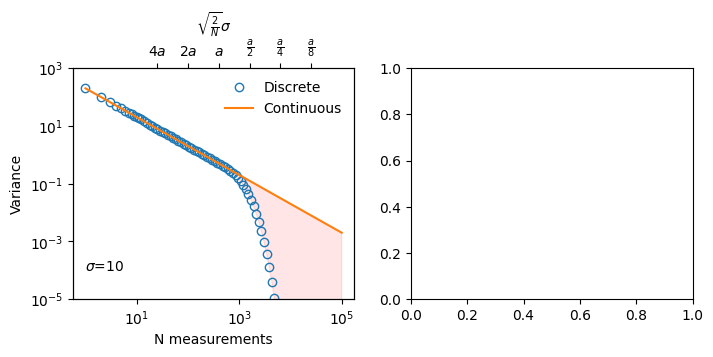

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

Ns = np.unique(np.logspace(0, 5, 100).astype(int))
n = len(Ns)

variances = np.zeros((n, ))
means = np.zeros((n, ))
for _i, N in enumerate(Ns):
  sigmaM = 10
  xbar = 100
  def normalisation_factor(xbar, sigma):
    ns = np.arange(-100000, 100000, 1).astype(float)
    res = np.sum(gaussianExponential(ns, xbar-int(xbar), sigma))
    return res

  def d_distribution(d, xbar, N, sigma):
    return gaussianExponential(d, xbar, sigma*np.sqrt(2/N))/normalisation_factor(xbar, sigma*np.sqrt(2/N))

  ds = np.arange(-200, 200) + 100

  pd = d_distribution(ds, xbar, N, sigmaM)

  variances[_i] = np.sum(ds**2*pd) - np.sum(ds*pd)**2
  means[_i] = np.sum(ds*pd)

axs[0].plot(Ns, variances, 'o', markerfacecolor="None", label="Discrete")
axs[0].plot(Ns, 2/Ns * sigmaM**2, '-', label="Continuous")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim([1e-5, 1e3])
axs[0].set_xlabel("N measurements")
axs[0].set_ylabel("Variance")
axs[0].legend(frameon=False)
axs[0].text(1, 1e-4, r"$\sigma$=10")

xplot = Ns
y_discrete = variances
y_continuous = 2/Ns * sigmaM**2
indices_to_keep = (y_continuous/y_discrete) > 0.5
axs[0].fill_between(xplot[indices_to_keep], y_discrete[indices_to_keep], y_continuous[indices_to_keep], alpha=0.1, color='r')
ax = axs[0].twiny()


xticks = np.array([25, 100, 400, 16e2, 64e2, 256e2])
xticklabels = ["$4a$", "$2a$", "$a$", r"$\frac{a}{2}$", r"$\frac{a}{4}$", r"$\frac{a}{8}$"]
ax.set_xscale("log")
ax.set_xlabel(r"$\sqrt{\frac{2}{N}}\sigma$")
ax.set_xticks(xticks, xticklabels)
ax.set_xticklabels(xticklabels)
ax.set_xlim(axs[0].get_xlim())



Fig3b

/tmp/ipykernel_3191735/4213755448.py:27: RuntimeWarning: Mean of empty slice
  d_mean[_i,i] = np.nanmean(d[_i],axis=(0,1))


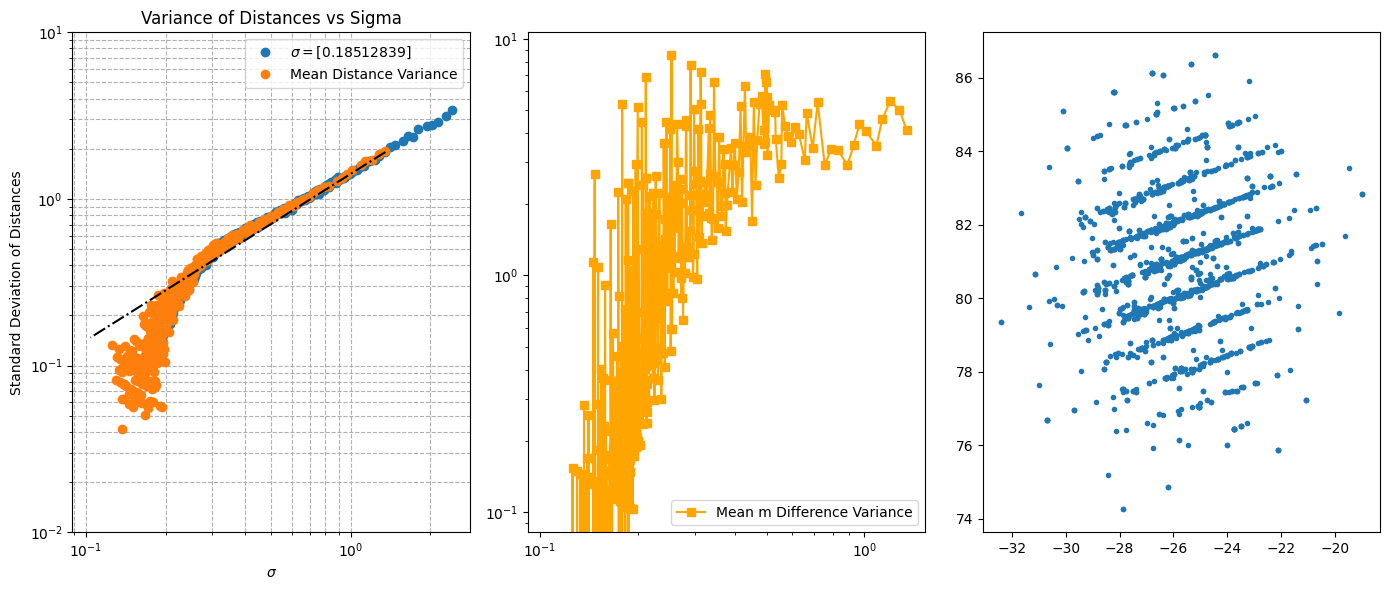

In [16]:

# Plot experimental data

# Prepare the plot
fig, ax = plt.subplots(1, 3, figsize=[14, 6])

i = 0
data_minimize = np.load('diamond_minimize_xi_sigma_M10_returnMN_100Trail.npz') # import data from emitterExperimentMLE
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']

N = M[0]
d = np.full((len(sigma_range),N,N),np.nan)
d_mean = np.zeros([len(sigma_range),11])
d_m = np.full((N,N),np.nan)
d_m_mean = np.zeros([len(sigma_range),11])
for _i,sigma in (enumerate(sigma_range)):
    for _j in range(M[0]-1):
        for _k in range(_j+1,M[0]):
        # for _k in range(1,2):
            d_m[_j,_k] = np.var(predicted_MN[_i,:,_j,0] - predicted_MN[_i,:,_k,0])
            dist = np.sqrt(np.square(predict_positions[_i,:,_j,0] - predict_positions[_i,:,_k,0])+np.square(predict_positions[_i,:,_j,1] - predict_positions[_i,:,_k,1]))
            d[_i,_j,_k] = np.var(dist)

    d_mean[_i,i] = np.nanmean(d[_i],axis=(0,1))

# Get the shape of the array
m, _, n = d.shape
distance = np.sqrt(np.square(predict_positions[:,:,0,0] - predict_positions[:,:,1,0])+np.square(predict_positions[:,:,0,1] - predict_positions[:,:,1,1]))

ax[0].loglog(sigma_range.ravel(),np.sqrt(d_mean[:,i]),'o',label=f"$\sigma=${sigma}")

ax[0].set_xscale("log")
ax[0].set_yscale("log")


# Load the new data file with dynamic N
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/diamond_minimize_xi_M5_sigma_dynamic_N.npz')  # Update the filename if different

# Extract relevant data
sigma_values = data_minimize['sigma_values']           # Shape: (sigma_sweepNumber,)
N_values = data_minimize['N_values']                 # Shape: (sigma_sweepNumber,)
predicted_positions = data_minimize['fitted_positions']      # Shape: (sigma_sweepNumber, max_N, M, 2)
predicted_MN = data_minimize['fitted_mn']                   # Shape: (sigma_sweepNumber, max_N, M, 2)
original_positions = data_minimize['original_measurements']

# Assuming M is fixed across simulations
M = 5
max_N = predicted_positions.shape[1]  # Maximum number of simulations across all sigma

# Initialize variables to store computed variances
# We'll compute variance across simulations for each sigma
# For example, variance of distances between emitter pairs across simulations
# Initialize arrays with appropriate dimensions and NaN padding
d = np.full((len(sigma_values), M, M), np.nan)  # Variance of distances
d_m = np.full((len(sigma_values), M, M), np.nan)  # Variance of m differences
d_mean_ref = np.full(len(sigma_values), np.nan)   # Mean variance per sigma

# Iterate over each sigma to compute variances
for i, sigma in enumerate(sigma_values):
    N = N_values[i]  # Number of valid simulations for this sigma
    if N < 2:
        print(f"Sigma index {i} with sigma={sigma} has less than 2 simulations. Skipping variance computation.")
        continue  # Variance requires at least two data points

    # Extract the valid simulations for this sigma
    # Shape: (N, M, 2)
    current_predicted_MN = predicted_MN[i, :N, :, :]  # [N, M, 2]
    current_predict_positions = predicted_positions[i, :N, :, :]  # [N, M, 2]

    # Compute variance of m differences across simulations
    # m corresponds to the first component (index 0) of predicted_MN
    m_diffs = current_predicted_MN[:, :, 0]  # Shape: (N, M)
    # Compute pairwise differences between emitters
    for j in range(M - 1):
        for k in range(j + 1, M):
            # Compute the variance of the difference in m for emitter pair (j, k)
            diff = m_diffs[:, j] - m_diffs[:, k]  # Shape: (N,)
            d_m[i, j, k] = np.var(diff)
    
    # Compute variance of distances between emitter pairs across simulations
    for j in range(M - 1):
        for k in range(j + 1, M):
            # Compute distances for each simulation
            dx = current_predict_positions[:, j, 0] - current_predict_positions[:, k, 0]
            dy = current_predict_positions[:, j, 1] - current_predict_positions[:, k, 1]
            distances = np.sqrt(dx**2 + dy**2)  # Shape: (N,)
            d[i, j, k] = np.nanvar(distances)
    
    # Compute the mean variance across all emitter pairs for this sigma
    # Ignore NaN values
    d_mean_ref[i] = np.nanmean(d[i])


# --- Plot 1: Variance of Distances vs Sigma ---
ax[0].loglog(sigma_values, np.sqrt(d_mean_ref), 'o', label='Mean Distance Variance')
ax[0].set_xlabel(r'$\sigma$')
ax[0].set_ylabel('Standard Deviation of Distances')
ax[0].set_title('Variance of Distances vs Sigma')
ax[0].grid(True, which="both", ls="--")
ax[0].legend()
ax[0].set_ylim([1e-2,1e1])

# --- Plot 2: Variance of m Differences vs Sigma ---
# Compute mean variance of m differences across emitter pairs
d_m_mean = np.nanmean(d_m, axis=(1, 2))  # Shape: (sigma_sweepNumber,)

ax[1].loglog(sigma_values, np.sqrt(d_m_mean), '-', marker='s', color='orange', label='Mean m Difference Variance')
ax[1].legend()

ax[0].loglog(sigma_values,sigma_values*np.sqrt(2),'-.',color='black')

ax[2].plot(predicted_positions[0,:,0,0]-predicted_positions[0,:,1,0],predicted_positions[0,:,0,1]-predicted_positions[0,:,1,1],'.')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


Fig4d,4e

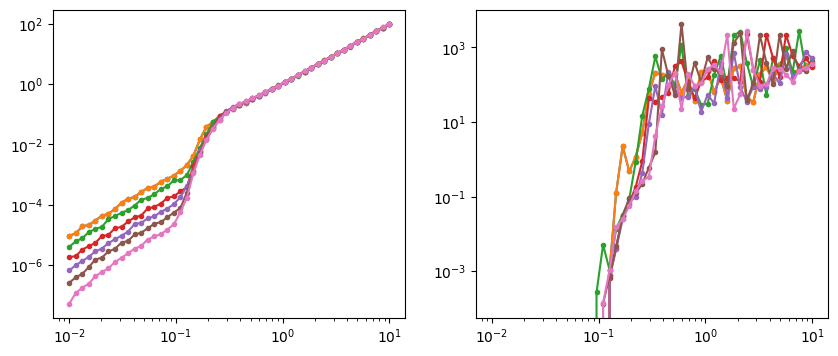

In [8]:
# Monte Carlo for Widefield DIGIT with different M
fig,ax = plt.subplots(1,2,figsize = [10,4])
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M5_returnMN.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
# initiate 
x_var = np.zeros([len(sigma_range),11])
m_var = np.zeros([len(sigma_range),11])
M_val = np.zeros([1,11])
i = 0
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M[0]}")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$M=${M[0]}")
M_val[0,i] = M[0]
i += 1


data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M10_returnMN.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']

for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M[0]}")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$M=${M[0]}")
M_val[0,i] = M[0]
i += 1



# Plot var(P)
import matplotlib.pyplot as plt
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M20_returnMN.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M[0]}")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$M=${M[0]}")
M_val[0,i] = M[0]
i += 1

# Plot var(P)
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M50_returnMN.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M[0]}")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$M=${M[0]}")
M_val[0,i] = M[0]
i += 1



# Plot var(P)
import matplotlib.pyplot as plt
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M100_returnMN.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M[0]}")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$M=${M[0]}")
M_val[0,i] = M[0]
i += 1




# Plot var(P)
import matplotlib.pyplot as plt
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M200_returnMN.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M[0]}")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$M=${M[0]}")
M_val[0,i] = M[0]
i += 1


# Plot var(P)
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M500_returnMN.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$M=${M[0]}")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$M=${M[0]}")
M_val[0,i] = M[0]
i += 1


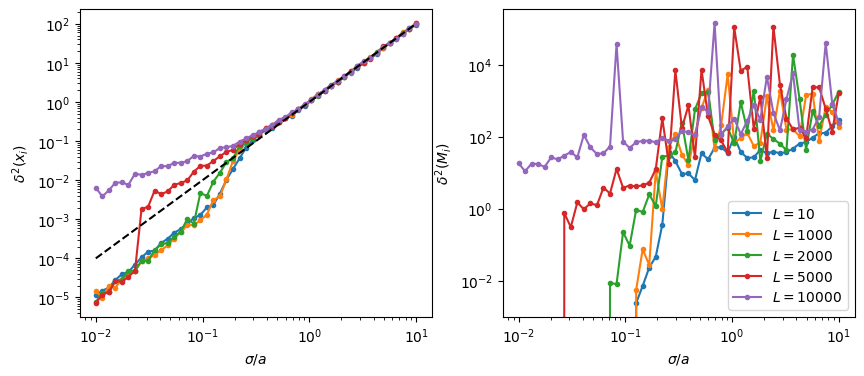

In [10]:
## Plot var(x) related to L
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize = [10,4])
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M10_returnMN_L100.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
# initiate 
x_var = np.zeros([len(sigma_range),9])
m_var = np.zeros([len(sigma_range),9])
i = 0
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0]-predicted_MN[_j,:,0:1,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$L=10$")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$L=10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        $")
i += 1




# Plot var(P)
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M10_returnMN_smallLatticeRange.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
theta_fitted = data_minimize['result_optimized'][:,:,0]
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$L=1000$")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$L=1000$")
i += 1




# Plot var(P)
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M10_returnMN_L2000.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
theta_fitted = data_minimize['result_optimized'][:,:,0]
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$L=2000$")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$L=2000$")
i += 1





# Plot var(P)
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M10_returnMN_L5000.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
theta_fitted = data_minimize['result_optimized'][:,:,0]
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$L=5000$")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$L=5000$")
i += 1




# Plot var(P)
data_minimize = np.load('/home/sophiayd/Documents/Velion/Error_Free_Imaging/minimize_xi_sigma_M10_returnMN_L10000.npz')
predict_positions = data_minimize['predicted_positions']
positions = data_minimize['original_positions']
sigma_range = data_minimize['sigma_values']
predicted_MN = data_minimize['predicted_MN']
M = data_minimize['M_values']
theta_fitted = data_minimize['result_optimized'][:,:,0]
# initiate 
for _j, sigma in (enumerate(sigma_range)): 
    x_var[_j,i] = np.mean(np.var(predict_positions[_j,:,:,0],axis=0))
    m_var[_j,i] = np.mean(np.var(predicted_MN[_j,:,:,0],axis=0))
ax[0].loglog(sigma_range,x_var[:,i],marker='.',label=f"$L=10000$")
ax[1].loglog(sigma_range,m_var[:,i],marker='.',label=f"$L=10000$")
i += 1

ax[0].loglog(sigma_range,sigma_range**2,'k--',label=f"$\sigma^2$")
ax[0].set_xlabel(r"$\sigma/a$")
ax[0].set_ylabel(f"$\delta^2(x_i)$")
ax[1].set_xlabel(r"$\sigma/a$")
ax[1].set_ylabel(f"$\delta^2(M_i)$")
plt.legend()